## Overview

This notebook will show you how to create and query a table or DataFrame that you uploaded to DBFS. [DBFS](https://docs.databricks.com/user-guide/dbfs-databricks-file-system.html) is a Databricks File System that allows you to store data for querying inside of Databricks. This notebook assumes that you have a file already inside of DBFS that you would like to read from.

This notebook is written in **Python** so the default cell type is Python. However, you can use different languages by using the `%LANGUAGE` syntax. Python, Scala, SQL, and R are all supported.

In [1]:
#!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=ad8d57f42466067b2ba9be919c798e51dac51d0f92d6c2d728518d6038427fea
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [3]:
#from pyspark.sql import SparkSession
#spark = SparkSession.builder.appName('Bank_deposit').getOrCreate()

In [4]:
# File location and type
file_location = '/content/bank.csv'
file_type = "csv"

df = spark.read.csv(file_location,header=True,inferSchema=True)

df.show()

+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|        job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|     admin.| married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|     admin.| married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41| technician| married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|   services| married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|     admin.| married| tertiary|     no|    184|     no|  

In [5]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [6]:
df.groupby('deposit').count().show()

+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



In [7]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')

In [8]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|               age|           balance|          duration|          campaign|             pdays|          previous|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|             11162|             11162|             11162|             11162|             11162|             11162|
|   mean|41.231947679627304|1528.5385235620856|371.99381831213043| 2.508421429851281| 51.33040673714388|0.8325568894463358|
| stddev|11.913369192215518| 3225.413325946149|347.12838571630687|2.7220771816614824|108.75828197197717| 2.292007218670508|
|    min|                18|             -6847|                 2|                 1|                -1|                 0|
|    max|                95|             81204|              3881|                63|               854|                58|
+-------

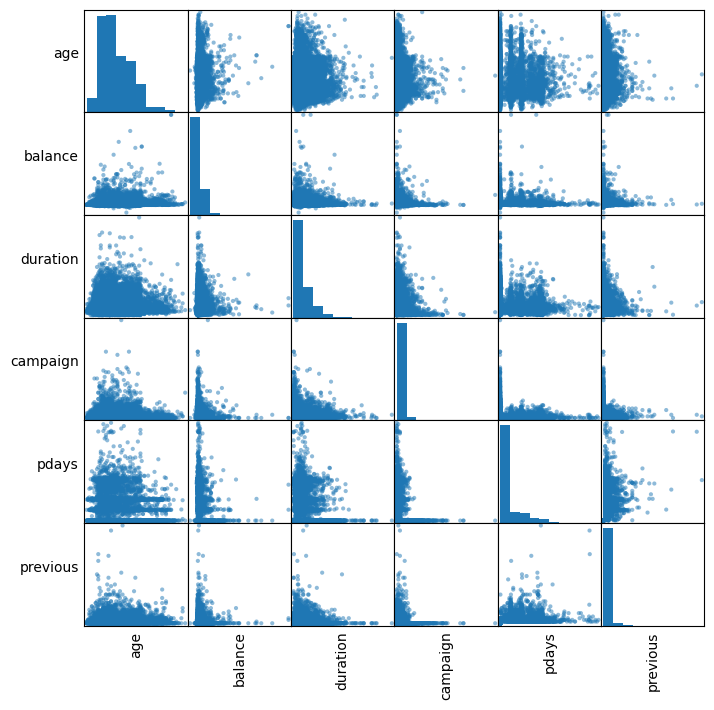

In [9]:
import pandas as pd
numeric_data = df.select(numeric_features).toPandas()
scatter_matrix = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8))

# Adjust labels and ticks
n = len(numeric_data.columns)
for i in range(n):
    v = scatter_matrix[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = scatter_matrix[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [10]:

df.columns

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'deposit']

In [11]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categorical_features = list(set(df.columns)-set(numeric_features))
categorical_features

['housing',
 'poutcome',
 'default',
 'marital',
 'job',
 'deposit',
 'education',
 'contact',
 'loan']

In [12]:
stages = list()
for categoricalCol in categorical_features :
    stringIndexer = StringIndexer(inputCol=categoricalCol,outputCol =categoricalCol+'index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols = [categoricalCol + 'classVec'])
    stages += [stringIndexer, encoder]

In [13]:
label_StringIdx = StringIndexer(inputCol='deposit',outputCol='label')
stages+=[label_StringIdx]

assemblerInputs = [c + "classVec" for c in categorical_features] + numeric_features
assembler = VectorAssembler(inputCols=assemblerInputs,outputCol='features')
stages+=[assembler]

In [14]:
cols = df.columns

In [15]:
from pyspark.ml.pipeline import Pipeline 
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label','features'] + df.columns[:-1]
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)
 |-- housingindex: double (nullable = false)
 |-- housingclassVec: vector (nullable = true)
 |-- poutcomeindex: double (nullable = false)
 |-- poutcomeclassVec: vector (nullable = true)
 |-- defaultindex: double (nullable = false)
 |-- defaultclassVec: vector (nullable = true)
 |-- maritalindex: double (nullable = false)
 |-- marit

In [16]:
finilized_data = df.select('features','label')

In [17]:
finilized_data.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(31,[1,4,5,10,19,...|  1.0|
|(31,[0,1,4,5,10,1...|  1.0|
|(31,[1,4,5,9,19,2...|  1.0|
|(31,[1,4,5,11,19,...|  1.0|
|(31,[0,1,4,5,10,2...|  1.0|
|(31,[1,4,6,7,20,2...|  1.0|
|(31,[1,4,5,7,20,2...|  1.0|
|(31,[1,4,12,19,23...|  1.0|
|(31,[1,4,5,9,19,2...|  1.0|
|(31,[1,4,6,11,19,...|  1.0|
|(31,[1,4,6,10,19,...|  1.0|
|(31,[1,4,5,8,19,2...|  1.0|
|(31,[1,4,5,7,20,2...|  1.0|
|(31,[1,4,6,8,20,2...|  1.0|
|(31,[1,4,6,9,20,2...|  1.0|
|(31,[1,4,7,20,23,...|  1.0|
|(31,[1,4,6,8,21,2...|  1.0|
|(31,[1,4,5,11,19,...|  1.0|
|(31,[1,4,5,10,19,...|  1.0|
|(31,[1,4,10,19,23...|  1.0|
+--------------------+-----+
only showing top 20 rows



In [21]:
train_data,test_data = finilized_data.randomSplit([0.7,0.3],seed = 2018)
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


In [22]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features',labelCol='label',maxIter=10)
model = lr.fit(train_data)

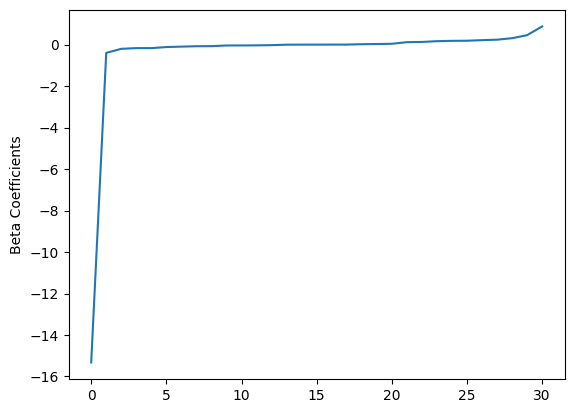

In [23]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

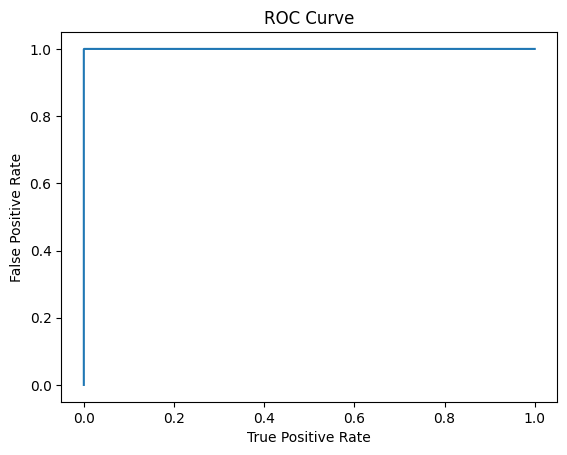

Training set areaUnderROC: 0.9999996751393783


In [24]:
trainingSummary = model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

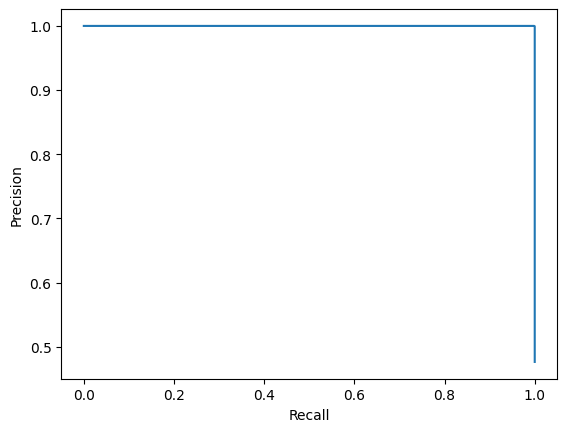

In [25]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [26]:
predictions = model.transform(test_data)
predictions.select('features', 'label', 'prediction').show()

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(31,[0,1,4,5,7,18...|  0.0|       0.0|
|(31,[0,1,4,5,7,18...|  0.0|       0.0|
|(31,[0,1,4,5,7,18...|  0.0|       0.0|
|(31,[0,1,4,5,7,18...|  0.0|       0.0|
|(31,[0,1,4,5,7,18...|  0.0|       0.0|
|(31,[0,1,4,5,7,18...|  0.0|       0.0|
|(31,[0,1,4,5,7,18...|  0.0|       0.0|
|(31,[0,1,4,5,7,18...|  0.0|       0.0|
|(31,[0,1,4,5,7,18...|  0.0|       0.0|
|(31,[0,1,4,5,7,18...|  0.0|       0.0|
|(31,[0,1,4,5,7,18...|  0.0|       0.0|
|(31,[0,1,4,5,7,18...|  0.0|       0.0|
|(31,[0,1,4,5,7,18...|  0.0|       0.0|
|(31,[0,1,4,5,7,18...|  0.0|       0.0|
|(31,[0,1,4,5,7,18...|  0.0|       0.0|
|(31,[0,1,4,5,7,18...|  0.0|       0.0|
|(31,[0,1,4,5,7,18...|  0.0|       0.0|
|(31,[0,1,4,5,7,18...|  0.0|       0.0|
|(31,[0,1,4,5,7,18...|  0.0|       0.0|
|(31,[0,1,4,5,7,18...|  0.0|       0.0|
+--------------------+-----+----------+
only showing top 20 rows



In [27]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9999996326913513


In [28]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train_data)
predictions = dtModel.transform(test_data)
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 1.0


In [29]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train_data)
predictions = rfModel.transform(test_data)
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 1.0


In [30]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train_data)
predictions = gbtModel.transform(test_data)
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 1.0


In [31]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train_data)
predictions = cvModel.transform(test_data)
evaluator.evaluate(predictions)

1.0